# STA4364 Midterm Exam
Matthias Rathbun  
10/24/2022

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels
from typing import Type
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn_pandas import DataFrameMapper
from sklearn.metrics import mean_squared_error

## Regression Diagnostic Class

In [2]:
class Linear_Reg_Diagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

"""

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)

    def __call__(self, plot_context='seaborn-paper'):
        # print(plt.style.available)
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(ax=ax[1,1])
            plt.show()

        self.vif_table()
        return fig, ax


    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.sort(residual_abs))
        abs_resid_top_3 = abs_resid[:3]
        for i, _ in enumerate(abs_resid_top_3):
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for r, i in enumerate(abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(np.flip(QQ.theoretical_quantiles, 0)[r], self.residual_norm[i]),
                ha='right', color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')
        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        xtemp, ytemp = self.__cooks_dist_line(0.5) # 0.5 line
        ax.plot(xtemp, ytemp, label="Cook's distance", lw=1, ls='--', color='red')
        xtemp, ytemp = self.__cooks_dist_line(1) # 1 line
        ax.plot(xtemp, ytemp, lw=1, ls='--', color='red')

        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        ax.legend(loc='upper right')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        print(vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y

## Import and Clean Data

In [3]:
df = pd.read_csv("midterm_data_1.csv", index_col = "row")
df = df.dropna()
df['feat.c'] = df['feat.c'].astype(int)
df = df.rename(columns={"feat.a": "A", "feat.b": "B", "feat.c":"C", "feat.d":"D", "feat.e":"E", "feat.f":"F", "feat.g":"G", "feat.h":"H", "feat.i":"I"})
df.head()


,response,A,B,C,D,E,F,G,H,I
row,,,,,,,,,,
1,1.658814,-0.879361,-2.297552,2,-2.052926,-1.458801,6.463630,2,-0.438952,-1.307249
2,10.691572,1.550930,-2.332102,4,1.110204,-1.744876,-11.834376,1,3.157077,-1.750373
3,32.508862,-1.506886,-5.306166,1,-1.814569,-3.747318,-18.031607,1,0.065876,-3.795091
4,37.747154,5.785842,-3.683903,2,6.453664,-3.645221,-10.534296,3,-0.293807,-3.495105
5,18.072661,1.988523,-3.895907,2,1.600221,-1.874998,-22.835629,1,2.482003,-1.888469


In [4]:
df = pd.get_dummies(df, columns = ['C','G'])
df.head()

,response,A,B,D,E,F,H,I,C_1,C_2,C_3,C_4,G_1,G_2,G_3
row,,,,,,,,,,,,,,,
1,1.658814,-0.879361,-2.297552,-2.052926,-1.458801,6.463630,-0.438952,-1.307249,0,1,0,0,0,1,0
2,10.691572,1.550930,-2.332102,1.110204,-1.744876,-11.834376,3.157077,-1.750373,0,0,0,1,1,0,0
3,32.508862,-1.506886,-5.306166,-1.814569,-3.747318,-18.031607,0.065876,-3.795091,1,0,0,0,1,0,0
4,37.747154,5.785842,-3.683903,6.453664,-3.645221,-10.534296,-0.293807,-3.495105,0,1,0,0,0,0,1
5,18.072661,1.988523,-3.895907,1.600221,-1.874998,-22.835629,2.482003,-1.888469,0,1,0,0,1,0,0


## Plots

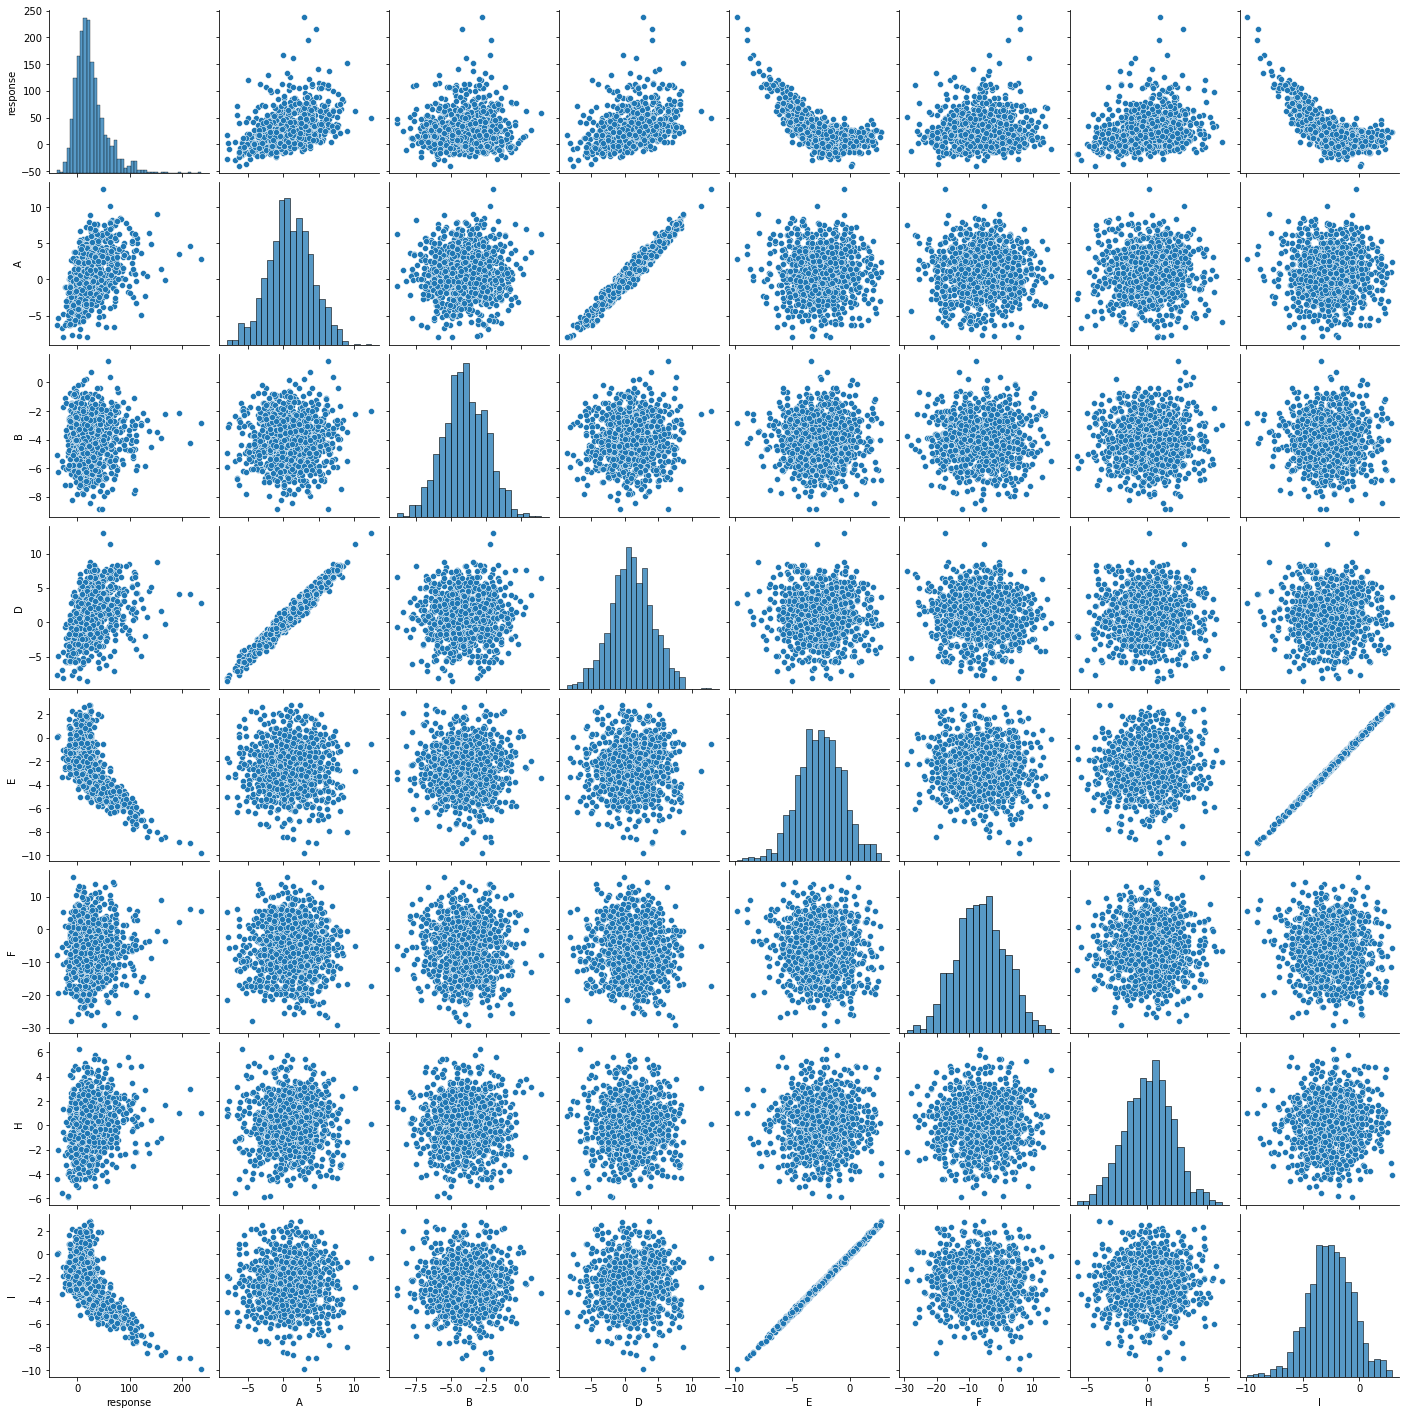

In [5]:
sns.pairplot(df.iloc[:,:8])

<AxesSubplot:>

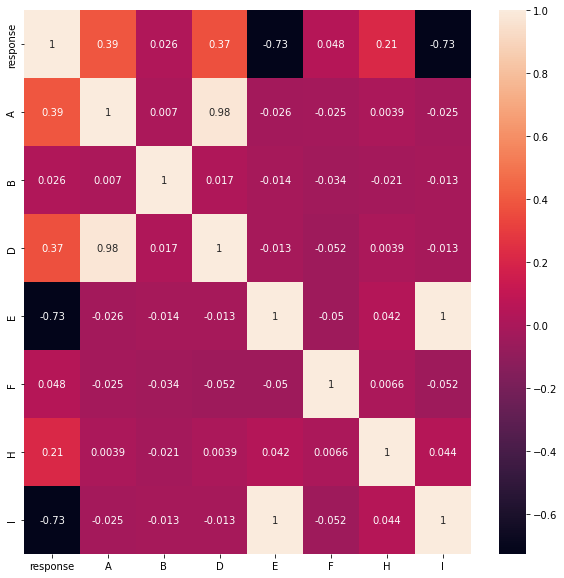

In [6]:
plt.figure(figsize = (10,10))
sns.heatmap(df.iloc[:,:8].corr(),annot = True)

## Train Test Split

In [7]:
X = df.iloc[:,1:]
y = df.iloc[:,:1]

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.25, random_state=101)

## First Order Model

In [9]:
X_train_c = sm.add_constant(X_train)
model = sm.OLS(y_train,X_train_c)
results = model.fit()
results.summary()

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     183.7
Date:                Mon, 24 Oct 2022   Prob (F-statistic):          1.10e-211
Time:                        18:52:09   Log-Likelihood:                -3106.6
No. Observations:                 747   AIC:                             6239.
Df Residuals:                     734   BIC:                             6299.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8786      1.167     -3.323      0.001      -6.170      -1.587
A              3.7415      0.895      4.179      0.000       1.984       5.499
B             -0.0530      0.362     -0.146      0.884      -0.763       0.657
D             -0.0715      0.875     -0.082      0.935      -1.789       1.646
E             -5.2308      5.757     -0.909      0.364     -16.532       6.071
F              0.1578      0.074      2.122      0.034       0.012       0.304
H              3.7632      0.286     13.148      0.000       3.201       4.325
I             -6.2058      5.744     -1.080      0.280     -17.483       5.071
C_1            1.1466      1.080      1.061      0.289      -0.975       3.268
C_2           -5.2634      0.999     -5.266      0.000      -7.225      -3.301
C_3            3.0249      1.051      2.879      0.004       0.962       5.087
C_4           -2.7867      1.035     -2.693      0.007      -4.819      -0.755
G_1           -1.1730      0.905     -1.297      0.195      -2.949       0.603
G_2           -0.0701      0.920     -0.076      0.939      -1.876       1.736
G_3           -2.6355      0.889     -2.965      0.003      -4.380      -0.891
==============================================================================
Omnibus:                      312.758   Durbin-Watson:                   1.951
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1907.076
Skew:                           1.784   Prob(JB):                         0.00
Kurtosis:                       9.967   Cond. No.                     1.02e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.11e-30. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [10]:
np.sqrt(results.scale)

15.621821010599554

The coefficients of Feature C mean what the predicted change in the response is when the feature equals that value. If Feature C = 1, response is expected to change by -0.52, if it equals 2, response changes by -6.93, and so on. The R squared of 0.75 means that 75% of the variance in the response is explained by the model. The RSE shows that the model predicts the response with an average error of 15.62. This number can be interpreded when compared to different model with same units in order to compare performance. The F statistic shows that the model with all the variables fits better than the model without variables (intercept-only)

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


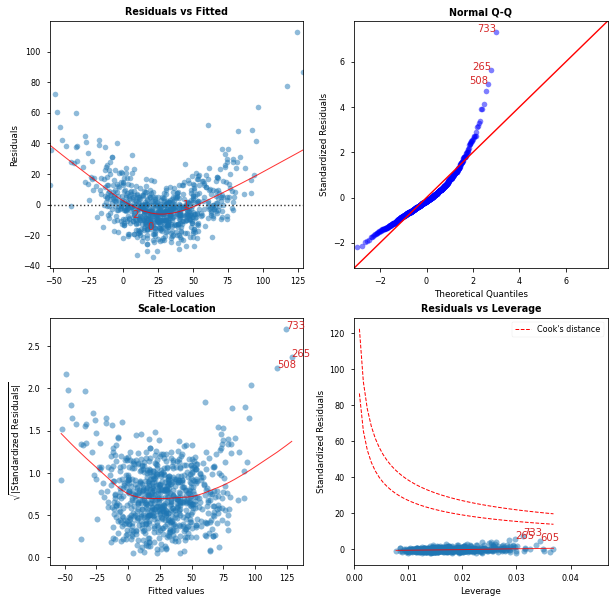

   Features  VIF Factor
0     const        0.00
2         B        1.01
6         H        1.03
5         F        1.04
1         A       24.09
3         D       24.18
4         E      399.93
7         I      399.93
8       C_1         inf
9       C_2         inf
10      C_3         inf
11      C_4         inf
12      G_1         inf
13      G_2         inf
14      G_3         inf


C:\Users\matth\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\matth\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [11]:
cls = Linear_Reg_Diagnostic(results)
fig, ax = cls()

The Linear Regression Diagnostic Plots show that there is a quadratic pattern in the residuals. This fails the Linearity and constant variance assumptions.

## Make Data for 2nd Order Model

In [12]:
poly = PolynomialFeatures(2, interaction_only=True)
X_train_p = pd.DataFrame(poly.fit_transform(X_train))
X_train_p.columns = poly.get_feature_names(X_train.columns)

X_test_p = pd.DataFrame(poly.fit_transform(X_test))
X_test_p.columns = poly.get_feature_names(X_test.columns)

In [13]:
X_train_p['A^2'] = X_train_p['A'].pow(2)
X_test_p['A^2'] = X_test_p['A'].pow(2)

X_train_p['B^2'] = X_train_p['B'].pow(2)
X_test_p['B^2'] = X_test_p['B'].pow(2)

X_train_p['D^2'] = X_train_p['D'].pow(2)
X_test_p['D^2'] = X_test_p['D'].pow(2)

X_train_p['E^2'] = X_train_p['E'].pow(2)
X_test_p['E^2'] = X_test_p['E'].pow(2)

X_train_p['F^2'] = X_train_p['F'].pow(2)
X_test_p['F^2'] = X_test_p['F'].pow(2)

X_train_p['H^2'] = X_train_p['H'].pow(2)
X_test_p['H^2'] = X_test_p['H'].pow(2)

X_train_p['I^2'] = X_train_p['I'].pow(2)
X_test_p['I^2'] = X_test_p['I'].pow(2)

In [14]:
X_train_p = X_train_p.iloc[:,1:]
X_test_p = X_test_p.iloc[:,1:]

In [15]:
y_train = y_train.reset_index().drop("row", axis = 1)
y_test = y_test.reset_index().drop("row", axis = 1)

In [16]:
for column in X_train_p.columns:
    if column.count('^') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('A') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('B') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('C') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('D') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('E') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('F') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('G') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('H') == 2:
        X_train_p.drop(column,axis=1, inplace=True)
    elif column.count('I') == 2:
        X_train_p.drop(column,axis=1, inplace=True)

In [17]:
for column in X_test_p.columns:
    if column.count('^') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('A') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('B') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('C') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('D') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('E') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('F') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('G') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('H') == 2:
        X_test_p.drop(column,axis=1, inplace=True)
    elif column.count('I') == 2:
        X_test_p.drop(column,axis=1, inplace=True)

## Full Model

In [18]:
X_train_p_c = sm.add_constant(X_train_p)
model_full = sm.OLS(y_train, X_train_p_c)
results_full = model_full.fit()
results_full.summary()

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     134.3
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:52:10   Log-Likelihood:                -2558.8
No. Observations:                 747   AIC:                             5282.
Df Residuals:                     665   BIC:                             5660.
Df Model:                          81                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.9099      1.227      2.371      0.018       0.500       5.320
A              3.8567      1.013      3.808      0.000       1.868       5.845
B              0.7810      0.496      1.574      0.116      -0.194       1.756
D             -1.8559      0.988     -1.879      0.061      -3.795       0.083
E             -7.3724      6.642     -1.110      0.267     -20.414       5.670
F             -0.0182      0.084     -0.216      0.829      -0.183       0.147
H              0.2626      0.323      0.813      0.416      -0.371       0.897
I              8.2915      6.578      1.260      0.208      -4.625      21.208
C_1            0.1144      1.320      0.087      0.931      -2.478       2.707
C_2           -1.7044      1.284     -1.328      0.185      -4.225       0.816
C_3            5.0610      1.392      3.637      0.000       2.328       7.794
C_4           -0.5611      1.259     -0.446      0.656      -3.033       1.911
G_1           -0.9852      1.175     -0.838      0.402      -3.292       1.322
G_2            3.2642      1.206      2.707      0.007       0.896       5.632
G_3            0.6309      1.173      0.538      0.591      -1.672       2.934
A B            0.4109      0.313      1.312      0.190      -0.204       1.026
A D           -1.2014      1.069     -1.124      0.261      -3.300       0.897
A E            9.5224      5.168      1.843      0.066      -0.624      19.669
A F           -0.0601      0.062     -0.964      0.335      -0.183       0.062
A H           -0.0429      0.242     -0.177      0.860      -0.518       0.432
A I           -9.0693      5.180     -1.751      0.080     -19.240       1.101
A C_1          1.6114      0.906      1.778      0.076      -0.168       3.391
A C_2          0.5045      0.873      0.578      0.563      -1.209       2.218
A C_3          1.0040      0.845      1.188      0.235      -0.656       2.664
A C_4          0.7369      0.852      0.865      0.387      -0.935       2.409
A G_1          1.0407      0.763      1.365      0.173      -0.457       2.538
A G_2          1.0505      0.751      1.399      0.162      -0.424       2.525
A G_3          1.7655      0.763      2.315      0.021       0.268       3.263
B D           -0.4541      0.308     -1.477      0.140      -1.058       0.150
B E           -3.0456      2.075     -1.468      0.143      -7.120       1.029
B F           -0.0035      0.026     -0.135      0.892      -0.054       0.047
B H           -0.2219      0.099     -2.232      0.026      -0.417      -0.027
B I            3.0914      2.064      1.497      0.135      -0.962       7.145
B C_1          0.0023      0.368      0.006      0.995      -0.720       0.724
B C_2          0.0649      0.352      0.184      0.854      -0.626       0.756
B C_3          0.6540      0.369      1.771      0.077      -0.071       1.379
B 

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


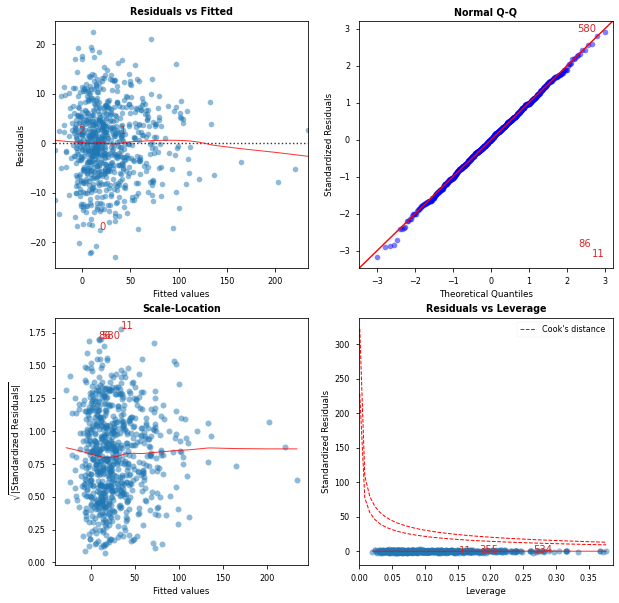

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
C:\Users\matth\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


    Features  VIF Factor
0      const        0.00
102      H^2        1.22
61       F H        1.95
101      F^2        3.00
31       B H        9.27
..       ...         ...
50     D G_3         inf
49     D G_2         inf
48     D G_1         inf
46     D C_3         inf
7          I         inf

[104 rows x 2 columns]


In [19]:
cls = Linear_Reg_Diagnostic(results_full)
fig, ax = cls()

## Intermediary Models

In [20]:
X_train_p_r = X_train_p.copy()
X_test_p_r = X_test_p.copy()
for column in X_train_p_r.columns:
    if results_full.pvalues.loc[column] > 0.38:
        X_train_p_r.drop(column,axis=1, inplace=True)
        X_test_p_r.drop(column,axis=1, inplace=True)

In [21]:
X_train_p_r_c = sm.add_constant(X_train_p_r)
model_3 = sm.OLS(y_train, X_train_p_r_c)
results_3 = model_3.fit()
results_3.summary()

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.942
Model:                            OLS   Adj. R-squared:                  0.938
Method:                 Least Squares   F-statistic:                     220.5
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:52:11   Log-Likelihood:                -2562.5
No. Observations:                 747   AIC:                             5229.
Df Residuals:                     695   BIC:                             5469.
Df Model:                          51                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2089      1.993      1.108      0.268      -1.704       6.122
A              4.5733      1.122      4.077      0.000       2.371       6.776
B              0.8821      0.755      1.168      0.243      -0.600       2.364
D             -2.3827      1.520     -1.567      0.118      -5.368       0.602
E            -11.2307     10.620     -1.057      0.291     -32.083       9.621
I             13.0433     10.535      1.238      0.216      -7.640      33.727
C_2           -1.7580      0.877     -2.005      0.045      -3.480      -0.036
C_3            5.5559      1.679      3.308      0.001       2.259       8.853
G_2            3.3193      1.921      1.728      0.084      -0.453       7.092
A B            0.3986      0.294      1.355      0.176      -0.179       0.976
A D           -1.1547      1.016     -1.137      0.256      -3.149       0.840
A E            9.8072      4.876      2.011      0.045       0.234      19.380
A F           -0.0068      0.013     -0.532      0.595      -0.032       0.018
A I           -9.3694      4.882     -1.919      0.055     -18.954       0.215
A C_1          0.9470      1.096      0.864      0.388      -1.206       3.100
A C_3          0.0769      0.222      0.347      0.729      -0.358       0.512
A G_1          1.3451      0.526      2.558      0.011       0.313       2.378
A G_2          1.0146      0.517      1.963      0.050   -1.92e-05       2.029
A G_3          2.2137      0.725      3.052      0.002       0.789       3.638
B D           -0.4367      0.287     -1.519      0.129      -1.001       0.128
B E           -3.2412      2.006     -1.616      0.107      -7.179       0.697
B H           -0.2361      0.055     -4.282      0.000      -0.344      -0.128
B I            3.2842      1.996      1.645      0.100      -0.635       7.203
B C_3          0.6425      0.433      1.483      0.139      -0.208       1.493
B G_2          0.5689      0.417      1.364      0.173      -0.250       1.388
B G_3          0.3314      0.268      1.236      0.217      -0.195       0.858
D E           -8.1971      4.772     -1.718      0.086     -17.567       1.172
D I            7.7594      4.776      1.625      0.105      -1.618      17.137
D C_1         -1.1211      1.065     -1.053      0.293      -3.211       0.969
D G_3         -1.3648      0.946     -1.443      0.150      -3.222       0.492
E H           -2.3694      1.447     -1.637      0.102      -5.211       0.472
E I            4.7519      1.476      3.219      0.001       1.854       7.650
E C_1         -9.4881      7.615     -1.246      0.213     -24.440       5.464
E C_3         11.6877      7.161      1.632      0.103      -2.372      25.747
E G_3         -7.7059      6.102     -1.263      0.207     -19.687       4.275
F H           -0.0289      0.018     -1.570      0.117      -0.065       0.007
F 

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


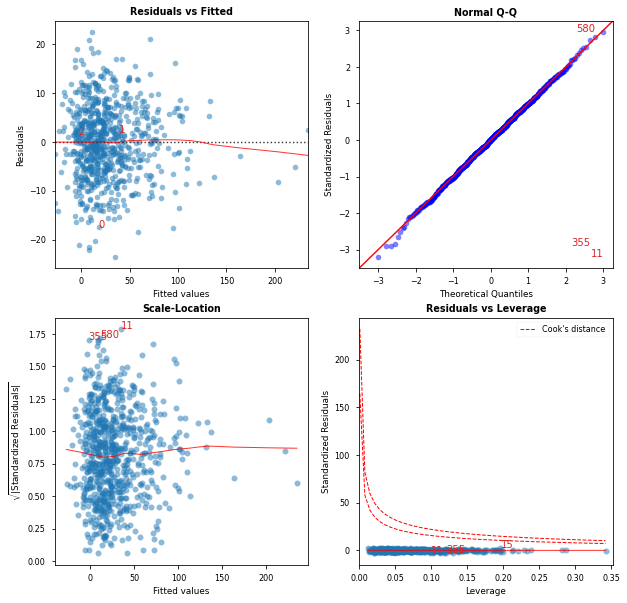

   Features  VIF Factor
38    H C_4        1.35
52      F^2        1.47
35      F H        1.58
39    H G_3        1.63
36    F C_1        1.73
43  C_1 G_1        1.81
15    A C_3        1.83
6       C_2        1.96
48  C_4 G_3        2.04
44  C_1 G_2        2.06
12      A F        2.15
21      B H        2.95
25    B G_3        3.97
23    B C_3        8.76
24    B G_2        9.68
8       G_2        9.95
50      B^2       14.86
2         B       17.95
28    D C_1       34.92
14    A C_1       34.93
29    D G_3       41.93
0     const       49.42
9       A B      201.52
19      B D      204.53
3         D      296.76
49      A^2      792.09
51      D^2      852.58
37      H I     1082.65
30      E H     1086.49
42    I G_3     1309.96
34    E G_3     1317.58
41    I C_3     1403.09
33    E C_3     1409.09
40    I C_1     1555.06
32    E C_1     1561.34
10      A D     3157.24
53      I^2     3929.62
31      E I     3964.13
22      B I     4455.20
20      B E     4481.91
5         I     

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [22]:
cls = Linear_Reg_Diagnostic(results_3)
fig, ax = cls()

In [23]:
X_train_p_r_2 = X_train_p_r.copy()
X_test_p_r_2 = X_test_p_r.copy()
for column in X_train_p_r.columns:
    if results_3.pvalues.loc[column] > 0.20:
        X_train_p_r_2.drop(column,axis=1, inplace=True)
        X_test_p_r_2.drop(column,axis=1, inplace=True)

In [24]:
X_train_p_r_2_c = sm.add_constant(X_train_p_r_2)
model_4 = sm.OLS(y_train, X_train_p_r_2_c)
results_4 = model_4.fit()
results_4.summary()

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.939
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     352.6
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:52:12   Log-Likelihood:                -2582.6
No. Observations:                 747   AIC:                             5229.
Df Residuals:                     715   BIC:                             5377.
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2644      0.850     -1.488      0.137      -2.933       0.404
A              3.9325      1.054      3.733      0.000       1.864       6.001
D             -1.3406      1.422     -0.943      0.346      -4.133       1.451
C_2           -2.2669      0.729     -3.111      0.002      -3.697      -0.836
C_3            7.6656      2.303      3.329      0.001       3.144      12.187
G_2            2.6079      1.835      1.421      0.156      -0.995       6.211
A B            0.1927      0.288      0.669      0.504      -0.373       0.758
A E           12.3640      4.801      2.575      0.010       2.938      21.790
A I          -12.0402      4.810     -2.503      0.013     -21.484      -2.596
A G_1          1.0235      0.500      2.046      0.041       0.041       2.006
A G_2          0.7052      0.495      1.424      0.155      -0.267       1.677
A G_3          2.2037      0.718      3.068      0.002       0.793       3.614
B D           -0.2300      0.281     -0.820      0.413      -0.781       0.321
B E           -0.3219      1.095     -0.294      0.769      -2.471       1.827
B H           -0.2553      0.054     -4.717      0.000      -0.362      -0.149
B I            0.1629      1.090      0.149      0.881      -1.978       2.304
B C_3          0.6906      0.436      1.584      0.114      -0.165       1.546
B G_2          0.4175      0.392      1.066      0.287      -0.351       1.186
D E          -11.3615      4.697     -2.419      0.016     -20.583      -2.140
D I           11.0402      4.703      2.347      0.019       1.807      20.274
D G_3         -1.6571      0.939     -1.764      0.078      -3.501       0.187
E H           -0.8567      0.066    -13.076      0.000      -0.985      -0.728
E I            5.5581      1.293      4.297      0.000       3.019       8.098
E C_3         15.1282      6.727      2.249      0.025       1.920      28.336
F H           -0.0264      0.018     -1.438      0.151      -0.062       0.010
H G_3          0.5509      0.294      1.876      0.061      -0.026       1.128
I C_3        -15.0915      6.729     -2.243      0.025     -28.303      -1.880
C_1 G_2        4.2964      1.365      3.148      0.002       1.617       6.976
C_3 G_2        1.1338      1.675      0.677      0.499      -2.154       4.422
C_3 G_3        0.8347      1.468      0.569      0.570      -2.048       3.717
B^2            0.0546      0.034      1.629      0.104      -0.011       0.120
F^2           -0.0030      0.002     -1.227      0.220      -0.008       0.002
I^2           -3.3008      1.286     -2.568      0.010      -5.825      -0.777
==============================================================================
Omnibus:                        0.060   Durbin-Watson:                   1.919
Prob(Omnibus):                  0.970   Jarque-Bera (JB):                0.129
Sk

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


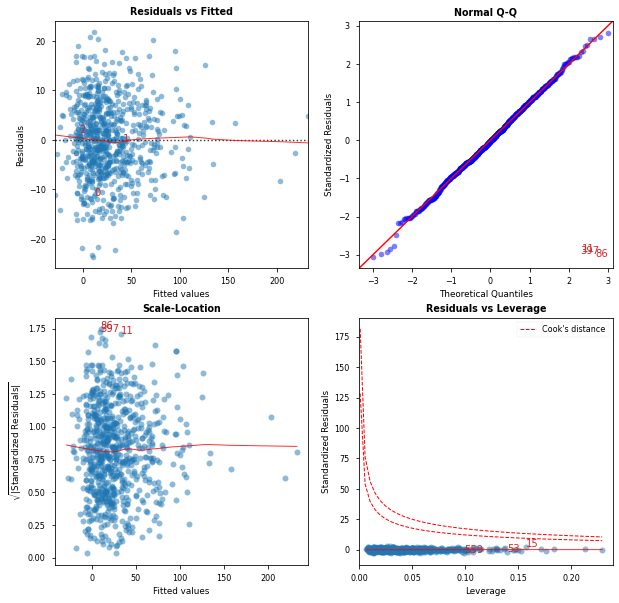

   Features  VIF Factor
31      F^2        1.09
3       C_2        1.32
24      F H        1.53
27  C_1 G_2        1.54
25    H G_3        1.55
29  C_3 G_3        1.93
21      E H        2.17
30      B^2        2.43
28  C_3 G_2        2.70
14      B H        2.77
17    B G_2        8.32
16    B C_3        8.64
0     const        8.76
5       G_2        8.85
4       C_3       11.94
20    D G_3       40.31
6       A B      188.39
12      B D      190.06
2         D      253.21
26    I C_3     1210.30
23    E C_3     1212.60
15      B I     1296.32
13      B E     1301.26
32      I^2     2960.24
22      E I     2968.38
18      D E    31761.15
19      D I    31835.97
7       A E    31974.90
8       A I    32037.87
9     A G_1         inf
10    A G_2         inf
11    A G_3         inf
1         A         inf


C:\Users\matth\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [25]:
cls = Linear_Reg_Diagnostic(results_4)
fig, ax = cls()

In [26]:
X_train_p_r_3 = X_train_p_r_2.copy()
X_test_p_r_3 = X_test_p_r_2.copy()
for column in X_train_p_r_2.columns:
    if results_4.pvalues.loc[column] > 0.20:
        X_train_p_r_3.drop(column,axis=1, inplace=True)
        X_test_p_r_3.drop(column,axis=1, inplace=True)

In [27]:
X_train_p_r_3_c = sm.add_constant(X_train_p_r_3)
model_5 = sm.OLS(y_train, X_train_p_r_3_c)
results_5 = model_5.fit()
results_5.summary()

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.938
Model:                            OLS   Adj. R-squared:                  0.936
Method:                 Least Squares   F-statistic:                     494.1
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:52:13   Log-Likelihood:                -2588.8
No. Observations:                 747   AIC:                             5224.
Df Residuals:                     724   BIC:                             5330.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4414      0.735     -1.960      0.050      -2.885       0.002
A              3.0724      0.249     12.325      0.000       2.583       3.562
C_2           -2.2765      0.722     -3.155      0.002      -3.693      -0.860
C_3            9.0147      2.124      4.245      0.000       4.846      13.184
G_2            1.1884      0.740      1.606      0.109      -0.265       2.641
A E           12.7765      4.786      2.670      0.008       3.381      22.172
A I          -12.5752      4.789     -2.626      0.009     -21.978      -3.173
A G_1          0.7192      0.255      2.825      0.005       0.219       1.219
A G_2          0.3836      0.254      1.508      0.132      -0.116       0.883
A G_3          1.9696      0.662      2.975      0.003       0.670       3.269
B H           -0.2651      0.053     -4.984      0.000      -0.370      -0.161
B C_3          0.7798      0.432      1.806      0.071      -0.068       1.627
D E          -11.5579      4.676     -2.472      0.014     -20.739      -2.377
D I           11.3598      4.677      2.429      0.015       2.177      20.543
D G_3         -1.7344      0.859     -2.019      0.044      -3.420      -0.048
E H           -0.8497      0.064    -13.181      0.000      -0.976      -0.723
E I            5.1486      0.928      5.548      0.000       3.327       6.971
E C_3         15.8171      6.359      2.487      0.013       3.332      28.302
F H           -0.0233      0.018     -1.278      0.202      -0.059       0.012
H G_3          0.5186      0.293      1.772      0.077      -0.056       1.093
I C_3        -15.6163      6.365     -2.453      0.014     -28.112      -3.120
C_1 G_2        4.0043      1.302      3.075      0.002       1.448       6.561
B^2            0.0042      0.025      0.168      0.867      -0.045       0.053
I^2           -2.9762      0.923     -3.226      0.001      -4.787      -1.165
==============================================================================
Omnibus:                        0.093   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.955   Jarque-Bera (JB):                0.144
Skew:                          -0.023   Prob(JB):                        0.930
Kurtosis:                       2.950   Cond. No.                     4.80e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.92e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


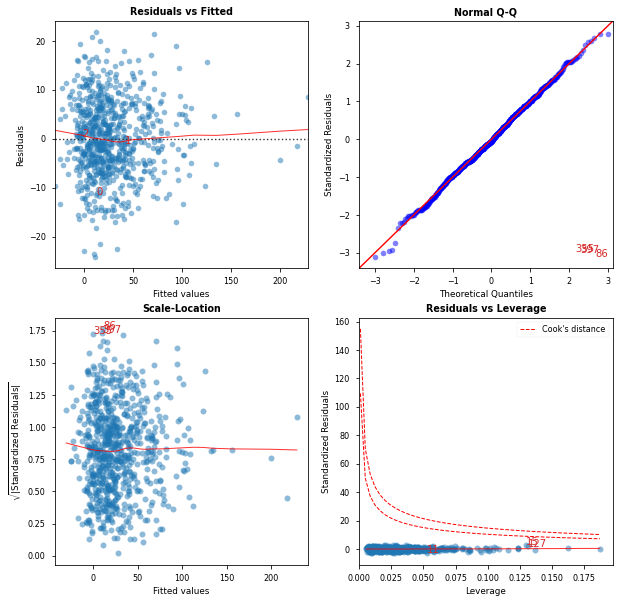

   Features  VIF Factor
2       C_2        1.29
22      B^2        1.35
21  C_1 G_2        1.40
4       G_2        1.43
18      F H        1.51
19    H G_3        1.54
15      E H        2.09
10      B H        2.67
0     const        6.53
11    B C_3        8.44
3       C_3       10.11
14    D G_3       33.55
20    I C_3     1078.20
17    E C_3     1078.95
23      I^2     1517.79
16      E I     1521.57
12      D E    31349.21
13      D I    31354.09
6       A I    31624.02
5       A E    31631.82
8     A G_2         inf
7     A G_1         inf
1         A         inf
9     A G_3         inf


C:\Users\matth\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [28]:
cls = Linear_Reg_Diagnostic(results_5)
fig, ax = cls()

In [29]:
X_train_p_r_4 = X_train_p_r_3.copy()
X_test_p_r_4 = X_test_p_r_3.copy()
for column in X_train_p_r_3.columns:
    if results_5.pvalues.loc[column] > 0.05:
        X_train_p_r_4.drop(column,axis=1, inplace=True)
        X_test_p_r_4.drop(column,axis=1, inplace=True)

In [30]:
X_train_p_r_4_c = sm.add_constant(X_train_p_r_4)
model_6 = sm.OLS(y_train, X_train_p_r_4_c)
results_6 = model_6.fit()
results_6.summary()

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     632.6
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:52:13   Log-Likelihood:                -2595.0
No. Observations:                 747   AIC:                             5226.
Df Residuals:                     729   BIC:                             5309.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.1726      0.570     -2.057      0.040      -2.292      -0.054
A              3.5285      0.197     17.928      0.000       3.142       3.915
C_2           -2.1416      0.715     -2.993      0.003      -3.546      -0.737
C_3            5.9581      1.153      5.166      0.000       3.694       8.223
A E           12.0627      4.792      2.517      0.012       2.654      21.471
A I          -11.8842      4.797     -2.478      0.013     -21.301      -2.467
A G_1          0.2341      0.222      1.053      0.293      -0.202       0.671
A G_3          1.5530      0.891      1.743      0.082      -0.196       3.302
B H           -0.3260      0.047     -6.950      0.000      -0.418      -0.234
D E          -10.9865      4.679     -2.348      0.019     -20.172      -1.801
D I           10.8033      4.680      2.308      0.021       1.615      19.992
D G_3         -1.7922      0.861     -2.081      0.038      -3.483      -0.102
E H           -0.8613      0.064    -13.406      0.000      -0.987      -0.735
E I            5.1221      0.932      5.496      0.000       3.293       6.952
E C_3         14.6040      6.325      2.309      0.021       2.186      27.022
I C_3        -14.4318      6.333     -2.279      0.023     -26.865      -1.999
C_1 G_2        4.8182      1.182      4.076      0.000       2.497       7.139
I^2           -2.9534      0.926     -3.188      0.001      -4.772      -1.135
==============================================================================
Omnibus:                        0.001   Durbin-Watson:                   1.941
Prob(Omnibus):                  1.000   Jarque-Bera (JB):                0.019
Skew:                          -0.002   Prob(JB):                        0.991
Kurtosis:                       2.976   Cond. No.                         883.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


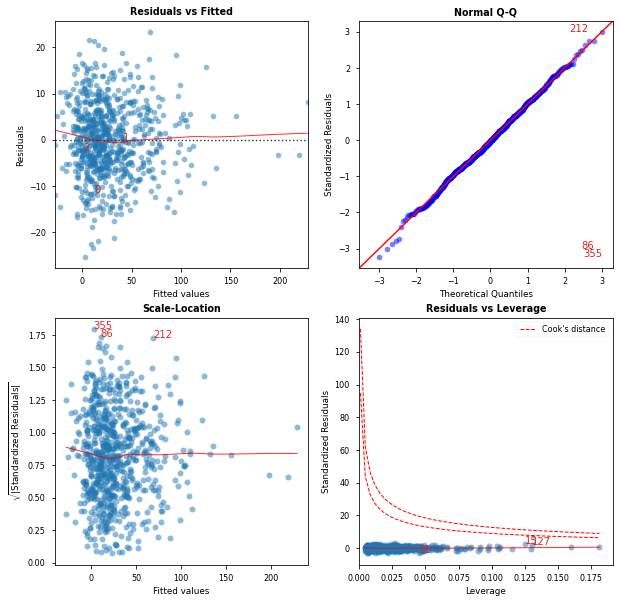

   Features  VIF Factor
16  C_1 G_2        1.14
2       C_2        1.25
6     A G_1        2.02
8       B H        2.05
12      E H        2.06
3       C_3        2.95
0     const        3.89
1         A        4.55
11    D G_3       33.41
7     A G_3       34.49
15    I C_3     1057.05
14    E C_3     1057.13
17      I^2     1515.83
13      E I     1519.51
9       D E    31082.04
10      D I    31091.62
4       A E    31415.52
5       A I    31415.80


In [31]:
cls = Linear_Reg_Diagnostic(results_6)
fig, ax = cls()

## Reduced Model

In [32]:
X_train_p_r_5 = X_train_p_r_4.copy()
X_test_p_r_5 = X_test_p_r_4.copy()
for column in X_train_p_r_4.columns:
    if results_6.pvalues.loc[column] > 0.05:
        X_train_p_r_5.drop(column,axis=1, inplace=True)
        X_test_p_r_5.drop(column,axis=1, inplace=True)

In [33]:
X_train_p_r_5_c = sm.add_constant(X_train_p_r_5)
model_reduced = sm.OLS(y_train, X_train_p_r_5_c)
results_reduced = model_reduced.fit()
results_reduced.summary()

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               response   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.935
Method:                 Least Squares   F-statistic:                     715.0
Date:                Mon, 24 Oct 2022   Prob (F-statistic):               0.00
Time:                        18:52:14   Log-Likelihood:                -2596.9
No. Observations:                 747   AIC:                             5226.
Df Residuals:                     731   BIC:                             5300.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0936      0.568     -1.925      0.055      -2.209       0.022
A              3.6477      0.169     21.637      0.000       3.317       3.979
C_2           -2.2053      0.714     -3.089      0.002      -3.607      -0.804
C_3            5.7405      1.146      5.007      0.000       3.490       7.991
A E           11.8973      4.778      2.490      0.013       2.516      21.278
A I          -11.8318      4.786     -2.472      0.014     -21.228      -2.436
B H           -0.3279      0.047     -6.987      0.000      -0.420      -0.236
D E          -10.7803      4.668     -2.309      0.021     -19.946      -1.615
D I           10.7010      4.674      2.290      0.022       1.526      19.876
D G_3         -0.4240      0.180     -2.352      0.019      -0.778      -0.070
E H           -0.8636      0.064    -13.471      0.000      -0.989      -0.738
E I            5.1271      0.933      5.495      0.000       3.295       6.959
E C_3         14.5780      6.324      2.305      0.021       2.163      26.993
I C_3        -14.4629      6.330     -2.285      0.023     -26.890      -2.035
C_1 G_2        4.6393      1.175      3.949      0.000       2.333       6.946
I^2           -2.9652      0.927     -3.197      0.001      -4.786      -1.144
==============================================================================
Omnibus:                        0.004   Durbin-Watson:                   1.930
Prob(Omnibus):                  0.998   Jarque-Bera (JB):                0.006
Skew:                          -0.002   Prob(JB):                        0.997
Kurtosis:                       2.987   Cond. No.                         878.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


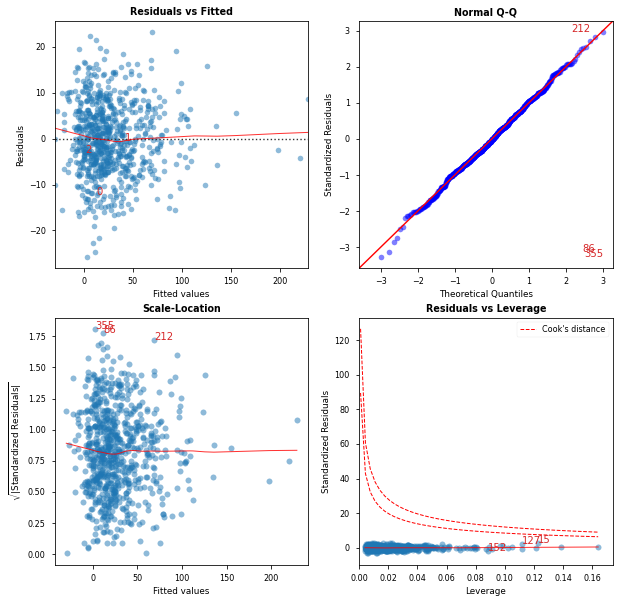

   Features  VIF Factor
14  C_1 G_2        1.12
2       C_2        1.24
9     D G_3        1.46
10      E H        2.05
6       B H        2.05
3       C_3        2.91
1         A        3.33
0     const        3.85
13    I C_3     1053.59
12    E C_3     1054.16
15      I^2     1515.54
11      E I     1519.34
7       D E    30867.66
8       D I    30926.69
4       A E    31154.42
5       A I    31203.94


In [34]:
cls = Linear_Reg_Diagnostic(results_reduced)
fig, ax = cls()

The Resudial Plot no longer contains a quadratic trend and is now horizontal compared to part b.

## Validation Set Testing

In [35]:
X_test_p_c = sm.add_constant(X_test_p)
X_test_p_r_5_c = sm.add_constant(X_test_p_r_5)

C:\Users\matth\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [36]:
y_pred_f = results_full.predict(X_test_p_c)
y_pred_r = results_reduced.predict(X_test_p_r_5_c)

In [37]:
mean_squared_error(y_test, y_pred_f)

79.79269272903343

In [38]:
mean_squared_error(y_test, y_pred_r)

80.93076620252883

MSE for the reduced and full models are very close. This does not indicate overfitting of the full model, but it is still preferable to use the model with 15 features instead of the one with 103 features if the performance on the validation set is similar. This could prevent future overfitting.

## Interval Testing

In [39]:
prediction_reduced = results_reduced.get_prediction(X_test_p_r_5_c)

In [40]:
Interval = prediction_reduced.conf_int()

In [41]:
obs = len(Interval)

In [42]:
i = 0
count = 0
for value in Interval:
    if y_test.iloc[i].values <= value[1] and y_test.iloc[i].values >= value[0]:
        count += 1
    i += 1

In [43]:
count

48

In [44]:
count/obs

0.1927710843373494